# Boussinesq equation

$$ u_{tt} - c^2 u_{xx} - \frac{\beta_1}{2\rho} (u^2)_{xx} + R^2[\frac{\alpha_1}{c^2} u_{tttt} + \alpha_2 u_{xxtt} + \alpha_3 c^2 u_{xxxx}] = 0 $$

In [1]:
import numpy as np
import scipy as sp
import scipy.integrate
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib
from IPython.display import HTML
plt.rcParams['animation.html'] = 'html5'
from log_progress import log_progress

In [37]:
# m to mm
coord_scale = 1
# s to microsec
time_scale = 1

# parameters
R = 5
rho = 1.06; E = 3.7; nu = 0.34; l = -18.9; m = -13.3; n = -10.0 # PS
c = np.sqrt(E/rho)

# nonlinearity and dispersion coefficients
beta1 = (3*E + 2*l*(1 - 2*nu)**3 + 4*m*(1 + nu)**2*(1 - 2*nu) + 6*n*nu**2)
beta2 = (3*E + 2*l*(1 - 2*nu)**3 + 4*m*(1 + nu)**2*(1 - 2*nu) + 6*n*nu**2)
beta3 = (3*E + 2*l*(1 - 2*nu)**3 + 4*m*(1 + nu)**2*(1 - 2*nu) + 6*n*nu**2)
alph1 = (1 + nu)/4
alph2 = -(1 + nu + nu**2)/2
alph3 = (1 + nu)/4

# regularisation
alph2 = alph1 + alph2 + alph3
alph1, alph3 = 0, 0

alph1m = R**2*alph1/c**2
alph2m = R**2*alph2
alph3m = R**2*alph3*c**2
beta1m = beta1/2/rho
beta2m = beta2/E/rho
beta3m = beta3/2/E**2/rho

## Soliton

Beta:             -27.642924800000003
Length parameter:  5.384194981300724
Linear velocity:   1.8683056596113627
Soliton velocity:  0.21971742515463744


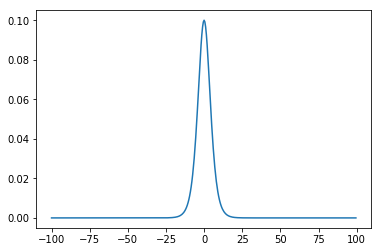

In [31]:
# domain
t0, tf = 0, 10
dt = 0.1
T = np.linspace(t0, tf, int((tf - t0)/dt + 1))
pN = 400
xl, xr = -100*coord_scale, 100*coord_scale
L = xr - xl
X = np.linspace(xl, xr, pN, endpoint=False)

# high frequency range for de-aliasing
hfreq1 = int(np.round(pN/3)) - 1
hfreq2 = int(np.round(2*pN/3)) + 1
da = np.ones_like(X)
da[hfreq1:hfreq2] = 0

# amplitude 
A = -0.1 # compression wave
#A = 0.15 # stretch wave

# soliton solution of the equation
D = R * np.sqrt(-4*(alph1*(A*beta1 + 3*E)**2 
                    + 3*E*(A*beta1 + 3*E)*alph2 
                    + 9*E**2*alph3)/(3*A*beta1*E))
V = np.sqrt(c**2 + A*beta1/3/rho) - c

def soliton(x, t):
    arg = (x - V*t)/D
    u = A*np.cosh(arg)**(-2)
    v = 2*V/D*np.tanh(arg)*u
    w = 2*A*V**2/D**2*(-2 + np.cosh(2*arg))*np.cosh(arg)**(-4)
    q = 4*A*V**3/D**3*(-5 + np.cosh(2*arg))*np.cosh(arg)**(-4)*np.tanh(arg)
    return [u, v, w, q]

print("Beta:            ", beta1)
print("Length parameter: ", D)
print("Linear velocity:  ", c)
print("Soliton velocity: ", V)

plt.plot(X, np.abs(soliton(X, 0)[0]))
plt.show()

In [44]:
#frequencies
xi = np.fft.fftfreq(len(X))*(len(X))*2*np.pi /(X[-1] - X[0])

# regularised model
def der2_move(t, y):
    u, v = y.reshape(2, -1)
    u_orig = np.fft.ifft(u)
    u2 = np.fft.fft(u_orig**2)
    du = v
    dv = (2j*c*xi*(1 - xi**2*alph2m)*v - alph2m*xi**4*c**2*u 
          - xi**2*(beta1m*u2))/(1 - xi**2*alph2m)
    return np.concatenate((du, dv))

# three dispersive terms
def der4(t, y):
    u, v, w, q = y.reshape(4, -1)
    u_orig = np.fft.ifft(u)
    u2 = np.fft.fft(u_orig**2)
    du, dv, dw = v, w, q
    dq = -((1 - alph2m*xi**2)*w + xi**2*(c**2 + alph3m*xi**2)*u 
           + xi**2*(beta1m*u2))/alph1m
    return np.concatenate((du, dv, dw, dq))

# xm = x - ct
def der4_move(t, y):
    u, v, w, q = y.reshape(4, -1)
    u_orig = np.fft.ifft(u)
    u2 = np.fft.fft(u_orig**2)
    du, dv, dw = v, w, q
    dq = (4j*alph1m*c*xi*q + (xi**2*(alph2m + 6*alph1m*c**2) - 1)*w 
          + 2j*c*xi*(1 - xi**2*(alph2m + 2*alph1m*c**2))*v 
          - xi**4*(alph1m*c**4 + alph2m*c**2 + alph3m)*u 
          - xi**2*(beta1m*u2))/alph1m
    return np.concatenate((du, dv, dw, dq))

Solve and plot

In [45]:
# de-aliased initial conditions
sol = soliton(X, 0)
u0 = np.fft.fft(sol[0])*da; v0 = np.fft.fft(sol[1])*da
#w0 = np.fft.fft(sol[2])*da; q0 = np.fft.fft(sol[3])*da

U = [sol[0],]; T_saved = [t0,] # containers for solution and time
err = [0.0,]
uk = np.concatenate((u0, v0))
ok = True # every loop iteration one iteration of RK is done
save_every = 1

for i in log_progress(range(1, len(T)), every=save_every):
    sln = sp.integrate.solve_ivp(der2_move, (0, dt), uk, method='RK45')
    u, v = sln.y[:, -1].reshape(2, -1)
    u *= da; v *= da
    if not i%save_every:
        U.append(np.fft.ifft(u).real)
        T_saved.append(T[i])
    uk = np.concatenate((u, v))
    if len(sln.t) > 2 and ok:
        print('Warning: more than one iteration was done (',len(sln.t) - 1,'). i = ', i)
        ok = False


VBox(children=(HTML(value=''), IntProgress(value=0)))

In [46]:
fig, axes = plt.subplots(figsize=(8, 4))
plt.title('Solution animation')
plt.xlim(X[0], X[-1]) 
plt.ylim(-0.5*np.abs(A), 1.2*np.abs(A))
plt.grid()
line1, = axes.plot([], [], lw=2)
line2, = axes.plot([], [], lw=2)
time_template = 'time = %.1f'
time_text = axes.text(0.8, 0.9, '', transform=axes.transAxes)
plt.minorticks_on()
plt.close()
dx = (X[-1] - X[0]) / pN

def plot_frame(i):
    line1.set_data(X, -U[i])
    time_text.set_text(time_template % T_saved[i])
    fig.canvas.draw()
    return fig

matplotlib.animation.FuncAnimation(fig, plot_frame, frames=len(U), interval=100, repeat=False)

## Shock wave

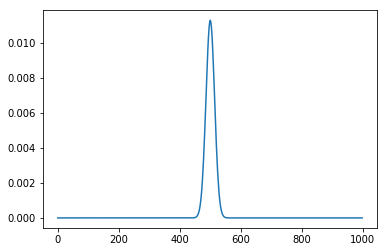

In [121]:
# domain
t0, tf = 0, 2000
dt = 10
T = np.linspace(t0, tf, int((tf - t0)/dt + 1))
pN = 500
xl, xr = 0, 1000
L = xr - xl
X = np.linspace(xl, xr, pN, endpoint=False)

# high frequency range for de-aliasing
hfreq1 = int(np.round(pN/3)) - 1
hfreq2 = int(np.round(2*pN/3)) + 1
da = np.ones_like(X)
da[hfreq1:hfreq2] = 0

def iv(x, t):
    A = -0.010
    D = 20
    u = 2*A/np.sqrt(np.pi)*np.exp(-(x - L/2)**2/D**2)
    v = x*0
    return [u, v]

plt.plot(X, -iv(X, 0)[0])
plt.show()

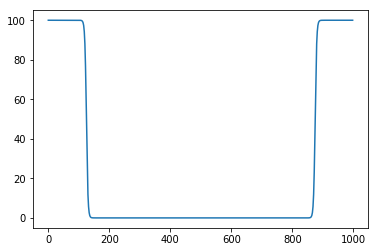

In [122]:
#frequencies
xi = np.fft.fftfreq(len(X))*(len(X))*2*np.pi /(X[-1] - X[0])

# sponge
def sponge_coef_func(x):
    amplt = 50
    kappa = 0.2
    lfrac = 3.0/4.0
    return amplt*( 1 + np.tanh(kappa*(x-L/2 - lfrac*L/2)) 
                  +1 - np.tanh(kappa*(x-L/2 + lfrac*L/2)))

sp_coef = sponge_coef_func(X)
plt.plot(X, sp_coef)
plt.show()

# regularised model
def der2_move(t, y):
    u, v = y.reshape(2, -1)
    u_orig = np.fft.ifft(u)
    v_orig = np.fft.ifft(v)
    u_sp, v_sp = np.fft.fft(u_orig*sp_coef), np.fft.fft(v_orig*sp_coef)
    u2 = np.fft.fft(u_orig**2)
    du = v - u_sp
    dv = (2j*c*xi*(1 - xi**2*alph2m)*v - alph2m*xi**4*c**2*u 
          - xi**2*(beta1m*u2) - v_sp)/(1 - xi**2*alph2m)
    return np.concatenate((du, dv))

# three dispersive terms
def der4(t, y):
    u, v, w, q = y.reshape(4, -1)
    u_orig = np.fft.ifft(u)
    u2 = np.fft.fft(u_orig**2)
    du, dv, dw = v, w, q
    dq = -((1 - alph2m*xi**2)*w + xi**2*(c**2 + alph3m*xi**2)*u 
           + xi**2*(beta1m*u2))/alph1m
    return np.concatenate((du, dv, dw, dq))

# xm = x - ct
def der4_move(t, y):
    u, v, w, q = y.reshape(4, -1)
    u_orig = np.fft.ifft(u)
    v_orig = np.fft.ifft(v)
    w_orig = np.fft.ifft(w)
    q_orig = np.fft.ifft(q)
    u_sp, v_sp = np.fft.fft(u_orig*sp_coef), np.fft.fft(v_orig*sp_coef)
    w_sp, q_sp = np.fft.fft(w_orig*sp_coef), np.fft.fft(q_orig*sp_coef)
    u2 = np.fft.fft(u_orig**2)
    du, dv, dw = v - u_sp, w - v_sp, q - w_sp
    dq = (4j*alph1m*c*xi*q + (xi**2*(alph2m + 6*alph1m*c**2) - 1)*w 
          + 2j*c*xi*(1 - xi**2*(alph2m + 2*alph1m*c**2))*v 
          - xi**4*(alph1m*c**4 + alph2m*c**2 + alph3m)*u 
          - xi**2*(beta1m*u2) - q_sp)/alph1m
    return np.concatenate((du, dv, dw, dq))

In [123]:
# de-aliased initial conditions
sol = iv(X, 0)
u0 = np.fft.fft(sol[0])*da; v0 = np.fft.fft(sol[1])*da
#w0 = np.fft.fft(sol[2])*da; q0 = np.fft.fft(sol[3])*da

U = [sol[0],]; T_saved = [t0,] # containers for solution and time
uk = np.concatenate((u0, v0))
save_every = 1

In [124]:
ok = True # every loop iteration one iteration of RK is done
for i in log_progress(range(1, len(T)), every=save_every):
    sln = sp.integrate.solve_ivp(der2_move, (0, dt), uk, method='RK45')
    u, v = sln.y[:, -1].reshape(2, -1)
    u *= da; v *= da#; w *= da; q *= da
    if not i%save_every:
        U.append(np.fft.ifft(u).real)
        T_saved.append(T[i])
    uk = np.concatenate((u, v))
    if len(sln.t) > 2 and ok:
        print('Warning: more than one iteration was done (',len(sln.t) - 1,'). i = ', i)
        ok = False


VBox(children=(HTML(value=''), IntProgress(value=0, max=200)))

In [126]:
fig, axes = plt.subplots(figsize=(8, 4))
plt.title('Solution animation')
plt.xlim(X[0], X[-1]) 
plt.ylim(-0.005, 0.015)
plt.grid()
line1, = axes.plot([], [], lw=2)
line2, = axes.plot([], [], lw=2)
time_template = 'time = %.1f'
time_text = axes.text(0.8, 0.9, '', transform=axes.transAxes)
plt.minorticks_on()
plt.close()
dx = (X[-1] - X[0]) / pN

def plot_frame(i):
    line1.set_data(X, -U[i])
    time_text.set_text(time_template % T_saved[i])
    fig.canvas.draw()
    return fig

matplotlib.animation.FuncAnimation(fig, plot_frame, frames=len(U), interval=100, repeat=False)

## Generation via tangential loading

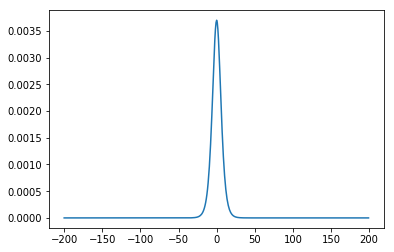

In [98]:
# domain
t0, tf = 0, 10000
dt = 1e-1
T = np.linspace(t0, tf, int((tf - t0)/dt + 1))
pN = 500
xl, xr = -200, 200
L = xr - xl
X = np.linspace(xl, xr, pN, endpoint=False)

# high frequency range for de-aliasing
hfreq1 = int(np.round(pN/3)) - 1
hfreq2 = int(np.round(2*pN/3)) + 1
da = np.ones_like(X)
da[hfreq1:hfreq2] = 0

def iv(x, t):
    D = (xr - xl)/80
    A = -1/2/D
    V = 0
    arg = (x - V*t)/D
    u = A*np.cosh(arg)**(-2)
    v = 2*V/D*np.tanh(arg)*u
    w = 2*A*V**2/D**2*(-2 + np.cosh(2*arg))*np.cosh(arg)**(-4)
    q = 4*A*V**3/D**3*(-5 + np.cosh(2*arg))*np.cosh(arg)**(-4)*np.tanh(arg)
    return [u, v, w, q]

g = 2/rho/R
def stress_tan(x, t):
    A_stress = 0.001*E
    V = 0
    D = A_stress*2000
    arg = ((x - V*t) - (xr + xl)/2)/D
    return A_stress*np.cosh(arg)**(-2)

plt.plot(X, stress_tan(X, 0))
plt.show()

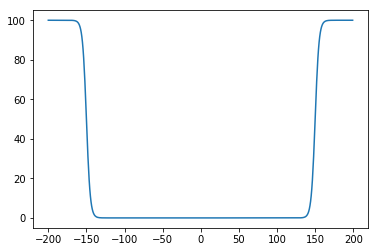

In [99]:
#frequencies
xi = np.fft.fftfreq(len(X))*(len(X))*2*np.pi /(X[-1] - X[0])

# sponge
def sponge_coef_func(x):
    amplt = 50
    kappa = 0.2
    lfrac = 3.0/4.0
    return amplt*( 1 + np.tanh(kappa*(x - lfrac*L/2)) 
                  +1 - np.tanh(kappa*(x + lfrac*L/2)))

sp_coef = sponge_coef_func(X)
plt.plot(X, sp_coef)
plt.show()

# regularised model
def der2_move(t, y):
    u, v = y.reshape(2, -1)
    u_orig = np.fft.ifft(u)
    v_orig = np.fft.ifft(v)
    s = np.fft.fft(stress_tan(X, t))
    u_sp, v_sp = np.fft.fft(u_orig*sp_coef), np.fft.fft(v_orig*sp_coef)
    u2 = np.fft.fft(u_orig**2)
    du = v - u_sp
    dv = (2j*c*xi*(1 - xi**2*alph2m)*v - alph2m*xi**4*c**2*u 
          - xi**2*(beta1m*u2) + 1j*xi*g*s - v_sp)/(1 - xi**2*alph2m)
    return np.concatenate((du, dv))

In [100]:
# de-aliased initial conditions
u0 = np.fft.fft(np.zeros(pN)); v0 = np.fft.fft(np.zeros(pN))

U = [np.zeros(pN),]; T_saved = [t0,] # containers for solution and time
uk = np.concatenate((u0, v0))
save_every = 1000

In [101]:
ok = True # every loop iteration one iteration of RK is done
for i in log_progress(range(1, len(T)), every=save_every):
    sln = sp.integrate.solve_ivp(der2_move, (0, dt), uk, method='RK45')
    u, v = sln.y[:, -1].reshape(2, -1)
    u *= da; v *= da
    if not i%save_every:
        U.append(np.fft.ifft(u).real)
        T_saved.append(T[i])
    uk = np.concatenate((u, v))
    if len(sln.t) > 2 and ok:
        print('Warning: more than one iteration was done (',len(sln.t) - 1,'). i = ', i)
        ok = False

VBox(children=(HTML(value=''), IntProgress(value=0, max=100000)))

In [102]:
fig, axes = plt.subplots(figsize=(8, 4))
plt.title('Solution animation')
plt.xlim(X[0], X[-1]) 
plt.ylim(-0.05, 0.12)
plt.grid()
line1, = axes.plot([], [], lw=2)
line2, = axes.plot([], [], lw=2)
time_template = 'time = %.1f'
time_text = axes.text(0.8, 0.9, '', transform=axes.transAxes)
plt.minorticks_on()
plt.close()
dx = (X[-1] - X[0]) / pN

def plot_frame(i):
    line1.set_data(X, -U[i])
    time_text.set_text(time_template % T_saved[i])
    fig.canvas.draw()
    return fig

matplotlib.animation.FuncAnimation(fig, plot_frame, frames=len(U), interval=100, repeat=False)